In [1]:
import torch
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

import os, time
import csv

### 1.Load dataset

In [2]:
data_root = '../feature_extractor/results'

classes = []
with open('../Class_mapping.csv') as f:
    csvreader = csv.reader(f)
    for row in csvreader:
        classes.append(row[0])

In [3]:
class_2_num = {classes[idx]:idx for idx in range(len(classes))}
class_2_num

{'ฉัน': 0,
 'เธอ': 1,
 'เขา': 2,
 'พวกเรา': 3,
 'สวัสดี': 4,
 'ชื่อ': 5,
 'ผู้ชาย': 6,
 'ผู้หญิง': 7,
 'ความรัก': 8,
 'ชอบ': 9,
 'ไม่ชอบ': 10,
 'ดีใจ': 11,
 'เสียใจ': 12,
 'โกรธ': 13,
 'ร้องไห้': 14,
 'ยาก': 15,
 'ง่าย': 16,
 'คิดถึง': 17,
 'รองเท้า': 18,
 'กางเกงยีนส์': 19,
 'หมวก': 20,
 'แว่นตา': 21,
 'นาฬิกาข้อมือ': 22,
 'ผ้าเช็ดหน้า': 23}

### DataLoader

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
class SignLanguageDataset(Dataset):
    def __init__(self, data_root, classes):
        self.data = []
        self.labels = []
        self.classes = classes
        for cls in classes:
            cls_dir = os.path.join(data_root, cls)
            files = os.listdir(cls_dir)
            files = [f for f in files if os.path.isfile(cls_dir+'/'+f) and not 'denormalized' in f]
            for f in files:
                
                seq = pd.read_csv(cls_dir + '/' + f)
                seq.drop(['index'], axis=1, inplace=True)
                self.data.append(seq)
                self.labels.append(cls)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        seq = self.data[idx]
        cls = self.labels[idx]
        label = class_2_num[cls]
        return seq, label

In [6]:
train_dataset = SignLanguageDataset(data_root, classes)

In [7]:
data, label = train_dataset[5]

print(data.shape, label)

(139, 150) 5


In [8]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [9]:
sample_frame_size = 5

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    xx = [torch.from_numpy(x[::5].to_numpy()).float() for x in xx]
    x_lens = torch.tensor([len(x) for x in xx])

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    return xx_pad, x_lens, torch.tensor(yy, dtype=torch.long)

In [10]:
batch_size = 8
dataloader = DataLoader(train_dataset, batch_size, collate_fn=pad_collate, shuffle=True)
testloader = DataLoader(train_dataset, batch_size, collate_fn=pad_collate)

In [11]:
out = next(iter(dataloader))
out[0].shape, out[1].shape, out[2].shape

(torch.Size([8, 35, 150]), torch.Size([8]), torch.Size([8]))

### Model

In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchinfo
from tqdm import tqdm

In [13]:
class LSTMClassifier(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers=2):
    super(LSTMClassifier, self).__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim, 64)
    self.fc2 = nn.Linear(64, output_dim)

  def forward(self, x, x_len):
    packed_x = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
    packed_output, (h, _) = self.lstm(packed_x)
    output = F.relu(self.fc1(h[-1]))
    logit = self.fc2(output)
    return logit

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier(150, 128, len(classes), n_layers=1)
model.to(device)

LSTMClassifier(
  (lstm): LSTM(150, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=24, bias=True)
)

In [15]:
model_path = 'simple_lstm_classifier.pth'
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

### Training loop

In [16]:
num_epochs = 50
idx = 0
best_val_acc = 0

training_losses = []
epoch_val_losses = []
epoch_train_losses = []
val_accs = []

for epoch in range(1, num_epochs+1): 
  running_loss = 0.0
  running_val_loss = 0.0
  print("EPOCH :", epoch)
  print("TRAINING LOOP")
  model.train() 
  for x_train, x_lens, labels in tqdm(dataloader): 
    optimizer.zero_grad() 

    x_train, labels = x_train.to(device), labels.to(device)
    y_pred = model(x_train, x_lens)

    loss = criterion(y_pred, labels)
    running_loss += loss.item()
    training_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    idx += 1
  avg_running_loss = running_loss / len(dataloader)

  model.eval()
  with torch.no_grad():
    val_pred = []
    val_true = []
    for x_val, x_lens, labels in tqdm(testloader): 
      x_val, labels = x_val.to(device), labels.to(device)
      pred = model(x_val, x_lens)
      loss = criterion(pred, labels)
      
      running_val_loss += loss.item()
      val_pred.append(pred.cpu().detach())
      val_true.append(labels.cpu().detach())
    
  avg_val_loss = running_val_loss / len(testloader)
  val_pred = torch.concatenate(val_pred, axis = 0).numpy()
  val_true = torch.concatenate(val_true, axis = 0).numpy()

  val_pred = np.argmax(val_pred, axis = 1)
  val_acc = accuracy_score(val_true, val_pred)

  # append to array for plotting
  epoch_train_losses.append(avg_running_loss)
  epoch_val_losses.append(avg_val_loss)
  val_accs.append(val_acc)

  if(best_val_acc < val_acc):
    best_val_acc = val_acc
    torch.save(model.state_dict(), model_path)

  print(f'training loss = {avg_running_loss:.3f}, \
    valudating loss = {avg_val_loss:.3f}, \
    valudating acc = {val_acc:.3f}\n\n')  

EPOCH : 1
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 214.30it/s]


training loss = 3.282,     valudating loss = 3.179,     valudating acc = 0.042


EPOCH : 2
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 214.26it/s]


training loss = 3.238,     valudating loss = 3.181,     valudating acc = 0.042


EPOCH : 3
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 230.86it/s]


training loss = 3.206,     valudating loss = 3.179,     valudating acc = 0.042


EPOCH : 4
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 214.28it/s]


training loss = 3.185,     valudating loss = 3.178,     valudating acc = 0.042


EPOCH : 5
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.34it/s]


training loss = 3.184,     valudating loss = 3.176,     valudating acc = 0.042


EPOCH : 6
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 300.03it/s]


training loss = 3.177,     valudating loss = 3.170,     valudating acc = 0.042


EPOCH : 7
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 230.80it/s]


training loss = 3.172,     valudating loss = 3.157,     valudating acc = 0.125


EPOCH : 8
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 300.01it/s]


training loss = 3.154,     valudating loss = 3.134,     valudating acc = 0.083


EPOCH : 9
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 272.68it/s]


training loss = 3.128,     valudating loss = 3.083,     valudating acc = 0.083


EPOCH : 10
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 299.92it/s]


training loss = 3.076,     valudating loss = 3.015,     valudating acc = 0.083


EPOCH : 11
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 199.99it/s]


training loss = 2.986,     valudating loss = 2.931,     valudating acc = 0.083


EPOCH : 12
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 375.09it/s]


training loss = 2.930,     valudating loss = 2.871,     valudating acc = 0.083


EPOCH : 13
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.30it/s]


training loss = 2.881,     valudating loss = 2.806,     valudating acc = 0.083


EPOCH : 14
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 375.03it/s]


training loss = 2.856,     valudating loss = 2.828,     valudating acc = 0.125


EPOCH : 15
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 375.02it/s]


training loss = 2.789,     valudating loss = 2.739,     valudating acc = 0.083


EPOCH : 16
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 428.65it/s]


training loss = 2.717,     valudating loss = 2.611,     valudating acc = 0.167


EPOCH : 17
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 90.91it/s]


training loss = 2.636,     valudating loss = 2.485,     valudating acc = 0.208


EPOCH : 18
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 230.78it/s]


training loss = 2.471,     valudating loss = 2.347,     valudating acc = 0.167


EPOCH : 19
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.36it/s]


training loss = 2.317,     valudating loss = 2.146,     valudating acc = 0.250


EPOCH : 20
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.22it/s]


training loss = 2.154,     valudating loss = 1.928,     valudating acc = 0.292


EPOCH : 21
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.33it/s]


training loss = 1.960,     valudating loss = 1.763,     valudating acc = 0.333


EPOCH : 22
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.49it/s]


training loss = 1.799,     valudating loss = 1.638,     valudating acc = 0.417


EPOCH : 23
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 375.13it/s]


training loss = 1.721,     valudating loss = 1.575,     valudating acc = 0.417


EPOCH : 24
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.38it/s]


training loss = 1.740,     valudating loss = 1.491,     valudating acc = 0.375


EPOCH : 25
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.37it/s]


training loss = 1.809,     valudating loss = 1.777,     valudating acc = 0.417


EPOCH : 26
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 375.05it/s]


training loss = 1.754,     valudating loss = 1.767,     valudating acc = 0.250


EPOCH : 27
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 375.08it/s]


training loss = 1.778,     valudating loss = 1.620,     valudating acc = 0.375


EPOCH : 28
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.49it/s]


training loss = 1.684,     valudating loss = 1.449,     valudating acc = 0.458


EPOCH : 29
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 375.14it/s]


training loss = 1.521,     valudating loss = 1.425,     valudating acc = 0.542


EPOCH : 30
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 299.96it/s]


training loss = 1.443,     valudating loss = 1.334,     valudating acc = 0.500


EPOCH : 31
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 300.09it/s]


training loss = 1.394,     valudating loss = 1.198,     valudating acc = 0.625


EPOCH : 32
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 272.79it/s]


training loss = 1.296,     valudating loss = 1.067,     valudating acc = 0.667


EPOCH : 33
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.28it/s]


training loss = 1.147,     valudating loss = 1.036,     valudating acc = 0.667


EPOCH : 34
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 428.54it/s]


training loss = 1.073,     valudating loss = 0.903,     valudating acc = 0.750


EPOCH : 35
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 300.04it/s]


training loss = 0.937,     valudating loss = 0.814,     valudating acc = 0.833


EPOCH : 36
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.31it/s]


training loss = 0.943,     valudating loss = 0.803,     valudating acc = 0.667


EPOCH : 37
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 300.09it/s]


training loss = 0.793,     valudating loss = 0.736,     valudating acc = 0.792


EPOCH : 38
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 428.54it/s]


training loss = 0.835,     valudating loss = 0.655,     valudating acc = 0.792


EPOCH : 39
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.43it/s]


training loss = 0.684,     valudating loss = 0.621,     valudating acc = 0.792


EPOCH : 40
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 375.15it/s]


training loss = 0.682,     valudating loss = 0.570,     valudating acc = 0.792


EPOCH : 41
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 375.11it/s]


training loss = 0.757,     valudating loss = 0.552,     valudating acc = 0.833


EPOCH : 42
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 374.98it/s]


training loss = 0.595,     valudating loss = 0.439,     valudating acc = 0.875


EPOCH : 43
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 299.96it/s]


training loss = 0.517,     valudating loss = 0.459,     valudating acc = 0.833


EPOCH : 44
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 428.59it/s]


training loss = 0.569,     valudating loss = 0.428,     valudating acc = 0.875


EPOCH : 45
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 299.95it/s]


training loss = 0.587,     valudating loss = 0.321,     valudating acc = 0.875


EPOCH : 46
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 374.94it/s]


training loss = 0.449,     valudating loss = 0.381,     valudating acc = 0.917


EPOCH : 47
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 374.90it/s]


training loss = 0.683,     valudating loss = 0.500,     valudating acc = 0.792


EPOCH : 48
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 375.11it/s]


training loss = 0.506,     valudating loss = 0.372,     valudating acc = 0.875


EPOCH : 49
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 272.51it/s]


training loss = 0.425,     valudating loss = 0.491,     valudating acc = 0.792


EPOCH : 50
TRAINING LOOP


100%|██████████| 3/3 [00:00<00:00, 333.31it/s]


training loss = 0.473,     valudating loss = 0.381,     valudating acc = 0.917




In [19]:
## TODO 3.4: visualize peformance on train , validation set
def visualize_loss_acc(training_losses, epoch_train_losses, epoch_val_losses, val_accs):
  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
  ax[0].plot(training_losses, label='training loss')
  ax[0].set_title('Training Loss')
  ax[1].plot(epoch_train_losses, label='train loss')
  ax[1].plot(epoch_val_losses, label='val loss')
  ax[1].set_title('Epoch Loss')
  ax[1].legend()
  ax[2].plot(val_accs, label='val acc')
  ax[2].set_title('Validation Accuracy')
  plt.show()

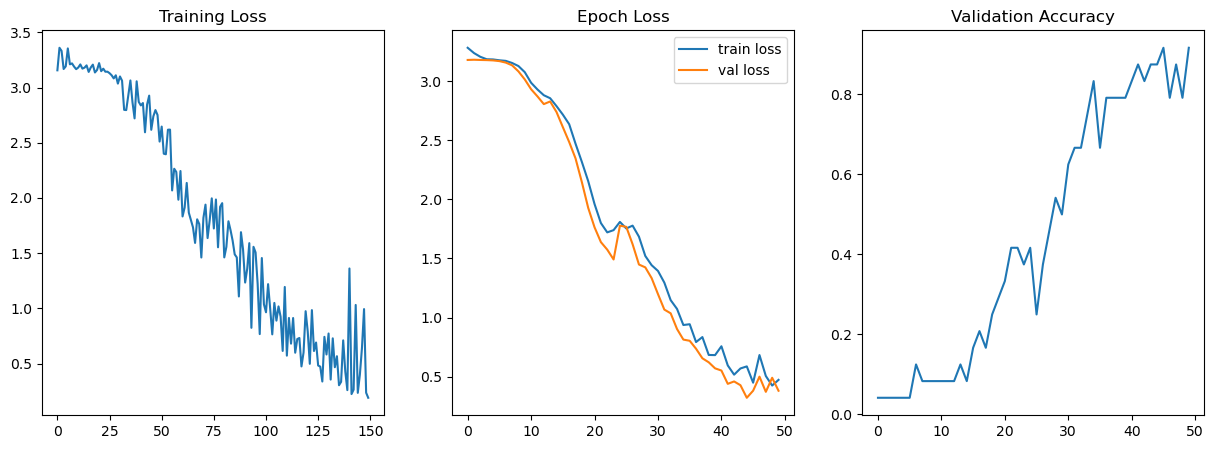

In [20]:
visualize_loss_acc(training_losses, epoch_train_losses, epoch_val_losses, val_accs)